# Find pierce points in an ionosphere

In [8]:
%matplotlib inline

import sys
from rascil.data_models import rascil_path, rascil_data_path

results_dir = '/tmp/'

import numpy

from astropy.coordinates import SkyCoord
from astropy import units as u

from matplotlib import pyplot as plt

from rascil.data_models.polarisation import PolarisationFrame

from rascil.processing_components import create_blockvisibility, show_image, create_named_configuration, \
    create_low_test_skycomponents_from_gleam, create_low_test_beam, apply_beam_to_skycomponent, \
    create_image_from_visibility, advise_wide_field, find_pierce_points

import logging
log = logging.getLogger()
log.setLevel(logging.DEBUG)
log.addHandler(logging.StreamHandler(sys.stdout))
mpl_logger = logging.getLogger("matplotlib") 
mpl_logger.setLevel(logging.WARNING) 



In [9]:
nfreqwin = 1
ntimes = 1
rmax = 300
frequency = numpy.linspace(0.8e8, 1.2e8, nfreqwin)
if nfreqwin > 1:
    channel_bandwidth = numpy.array(nfreqwin * [frequency[1] - frequency[0]])
else:
    channel_bandwidth = [0.4e8]
times = numpy.linspace(-numpy.pi / 4.0, numpy.pi / 4.0, ntimes)

phasecentre = SkyCoord(ra=+0.0 * u.deg, dec=-26.7 * u.deg, frame='icrs', equinox='J2000')
lowcore = create_named_configuration('LOWBD2', rmax=rmax)

block_vis = create_blockvisibility(lowcore, times, frequency=frequency,
                                   channel_bandwidth=channel_bandwidth, weight=1.0, phasecentre=phasecentre,
                                   polarisation_frame=PolarisationFrame("stokesI"), zerow=True)


create_named_configuration: LOWBD2
	(<Quantity -2565018.31203579 m>, <Quantity 5085711.90373391 m>, <Quantity -2861033.10788063 m>)
	GeodeticLocation(lon=<Longitude 116.76444824 deg>, lat=<Latitude -26.82472208 deg>, height=<Quantity 300. m>)
create_named_configuration: LOWBD2
	(<Quantity -2565018.31203579 m>, <Quantity 5085711.90373391 m>, <Quantity -2861033.10788063 m>)
	GeodeticLocation(lon=<Longitude 116.76444824 deg>, lat=<Latitude -26.82472208 deg>, height=<Quantity 300. m>)
create_configuration_from_file: Maximum radius 300.0 m includes 94 antennas/stations
create_configuration_from_file: Maximum radius 300.0 m includes 94 antennas/stations
create_blockvisibility: created 1 times
create_blockvisibility: created 1 times
create_blockvisibility: 4465 rows, 0.000 GB
create_blockvisibility: 4465 rows, 0.000 GB


### Find the station locations in geocentric coordinates

In [10]:
station_locations = block_vis.configuration.xyz.values

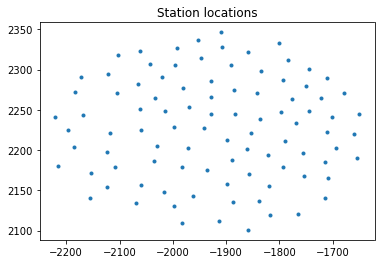

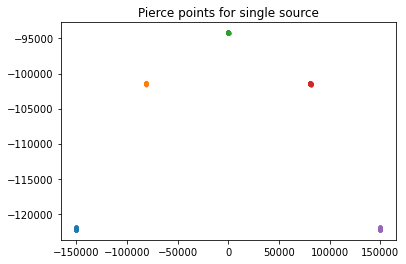

In [11]:
from rascil.processing_components.util import xyz_to_uvw

local_locations = xyz_to_uvw(station_locations, 0.0, -26.7 * u.deg)

ionosphere_height = 3e5
plt.clf()
plt.plot(local_locations[:, 0], local_locations[:, 1], '.')
plt.title('Station locations')
plt.show()

plt.clf()

for ha in numpy.linspace(-numpy.pi / 4.0, +numpy.pi / 4.0, 5):
    pp = find_pierce_points(local_locations, ha * u.rad, -45 * u.deg, phasecentre=phasecentre, height=ionosphere_height)
    plt.plot(pp[:, 0], pp[:, 1], '.')

plt.title('Pierce points for single source')

plt.show()


In [12]:
advice=advise_wide_field(block_vis, guard_band_image=5.0, delA=0.02)

npixel=advice['npixels2']
cellsize=advice['cellsize']

advise_wide_field: (max_wavelength) Maximum wavelength 3.747 (meters)
advise_wide_field: (max_wavelength) Maximum wavelength 3.747 (meters)
advise_wide_field: (min_wavelength) Minimum wavelength 3.747 (meters)
advise_wide_field: (min_wavelength) Minimum wavelength 3.747 (meters)
advise_wide_field: (maximum_baseline) Maximum baseline 142.1 (wavelengths)
advise_wide_field: (maximum_baseline) Maximum baseline 142.1 (wavelengths)
advise_wide_field: (maximum_w) Maximum w 0.0 (wavelengths)
advise_wide_field: (maximum_w) Maximum w 0.0 (wavelengths)
advise_wide_field: (diameter) Station/dish diameter 35.0 (meters)
advise_wide_field: (diameter) Station/dish diameter 35.0 (meters)
advise_wide_field: (primary_beam_fov) Primary beam 0.107 (rad) 6.13 (deg) 2.21e+04 (asec)
advise_wide_field: (primary_beam_fov) Primary beam 0.107 (rad) 6.13 (deg) 2.21e+04 (asec)
advise_wide_field: (image_fov) Image field of view 0.535 (rad) 30.7 (deg) 1.1e+05 (asec)
advise_wide_field: (image_fov) Image field of view 

Generate the model from the GLEAM catalog, including application of the primary beam.

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (0., -26.7)>, starting frequency 80000000.0 Hz, and bandwidth 40000000.0 Hz
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (0., -26.7)>, starting frequency 80000000.0 Hz, and bandwidth 40000000.0 Hz
create_image_from_visibility: uvmax = 142.126342 wavelengths
create_image_from_visibility: uvmax = 142.126342 wavelengths
create_image_from_visibility: Critical cellsize = 0.003518 radians, 0.201566 degrees
create_image_from_visibility: Critical cellsize = 0.003518 radians, 0.201566 degrees
create_image_from_visibility: Cellsize          = 0.00234533 radians, 0.134378 degrees
create_image_from_visibility: Cellsize          = 0.00234533 radians, 0.134378 degrees
create_image_from_visibility: 

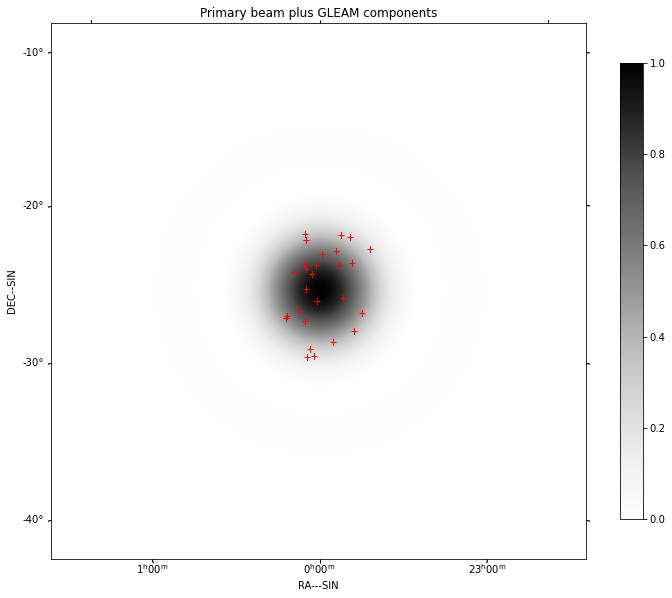

In [13]:
beam = create_image_from_visibility(block_vis, npixel=npixel, frequency=frequency,
                                    nchan=nfreqwin, cellsize=cellsize, phasecentre=phasecentre)

original_gleam_components = create_low_test_skycomponents_from_gleam(flux_limit=0.1,
                                                                     phasecentre=phasecentre, frequency=frequency,
                                                                     polarisation_frame=PolarisationFrame('stokesI'),
                                                                     radius=0.2)

beam = create_low_test_beam(beam, use_local=False)
pb_gleam_components = apply_beam_to_skycomponent(original_gleam_components, beam)
from rascil.processing_components.skycomponent import filter_skycomponents_by_flux

pb_gleam_components = filter_skycomponents_by_flux(pb_gleam_components, flux_min=1.0)
from matplotlib import pylab

pylab.rcParams['figure.figsize'] = (12.0, 12.0)
pylab.rcParams['image.cmap'] = 'rainbow'

show_image(beam, components=pb_gleam_components, cm='Greys', title='Primary beam plus GLEAM components')
print("Number of components %d" % len(pb_gleam_components))


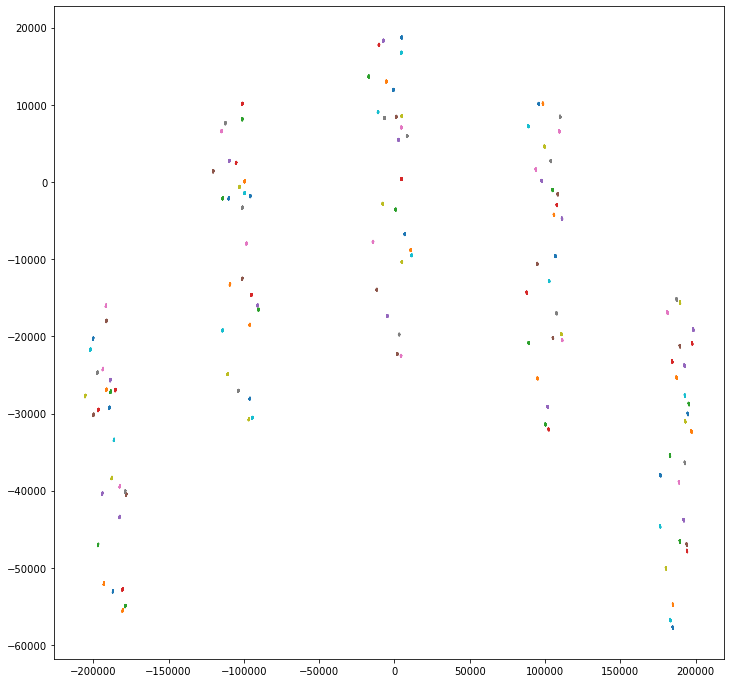

In [14]:
plt.clf()
for ha in numpy.linspace(-numpy.pi / 4.0, +numpy.pi / 4.0, 5):
    for comp in pb_gleam_components:
        pp = find_pierce_points(local_locations, (comp.direction.ra.rad + ha) * u.rad, comp.direction.dec, phasecentre=phasecentre, height=ionosphere_height)
        plt.plot(pp[:, 0], pp[:, 1])

#plt.xlim([-2.5e5, 2.5e5])
#plt.ylim([-2.5e5, 2.5e5])
plt.show()
